# Toxic Comment Classification

## Contents

* [Overview](#overview)
* [Data Preprocessing](#data_preprocessing)
* [Modeling](#modeling)
* [Evaluation](#evaluation)
* [References](#references)

## Overview <a id='overview'></a>

### Motivation
With the appearance of the World Wide Web and social media networks, vast amounts of textual data such as comments have occurred which also might contribute to negative side effects. For example, individuals can experience abuse and harassment due to messages as well as comments on several online platforms (e.g. Facebook). Due to the huge amount of data, it is impossible to remove all these toxic comments which lead to the necessity of automatic toxic comment detection by using computer-based algorithms. However, the processing and understanding of natural language by machines is a complex task. The subfield Natural Language Processing (NLP) deals with various techniques and methods for solving this problem. For toxic comment detection, several methods for text classification can be used such as classical machine learning or advanced deep learning techniques. A high accuracy of toxic comment classification can therefore automatize the detection and filtering of undesired text documents.

### Dataset
The dataset is published by the Conversation AI team founded by Jigsaw and Google who study negative online behaviors, like toxic comments. Therefore, they introduced the **Toxic Comment Classification Challenge** on Kaggle to improve the performance of toxic comment detection. The data used consists of a train and test set with 159,571 and 63,978 observations (after removing missing labels), respectively. The features include the id, comment and several labels for classifying the comments into different types of toxicity.

The original dataset can be found [here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview) where you also can find more information and approaches for tackling this text classification problem [1].

### Target Feature
The target output consists of six categorical features and represents a multi-label classification problem which means to assign each observation a set of target labels. Thereby, the target labels are denoted as *toxic*, *severe_toxic*, *obscene*, *threat*, *insult*, *identity_hate*.

### Methodology
As first step, the dataset is preprocessed considering irrelevant features and missing values if present. We don't expect much effort for this step as the provided dataset is already preprocessed due to the nature of Kaggle competitions. Subsequently, the data is prepared for machine learning/deep learning models by performing common NLP approaches such as removing of stopwords, tokenizing, padding and word embeddings. After these steps, we consider Logistic Regression as simple machine learning and Recurrent Neural Networks as deep learning classification technique.

For the Logistic Regression model, we are using the Term Frequency-Inverse Document Frequency (TF-IDF) algorithm for vectorizing the textual comments into meaningful vectors with numerical values. TF-IDF is a common algorithm which is used for machine learning models in NLP tasks. The optimal model hyperparameters are identified by applying a grid search for the Logistic Regression model in a 5-fold cross-validation fashion using the accuracy as scoring function. As deep learning model, we use a Gated Recurrent Unit (GRU) network with two dense layers and binar crossentropy as loss-function. Thereby, the first layer represents an embedding with a Word2Vec weighting matrix with 300-dimensional vectors as word representations.

Lastly, both models are compared considering the accuracy and Area-Under-Curve (AUC) metrics.

## Data Preprocessing <a id='data_preprocessing'></a>

### Imports

In [1]:
# For readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline
%config InlineBackend.figure_fformat = 'retina'
plt.style.use("ggplot")

# For reproducibility
np.random.seed(999)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\seebe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Deep Learning models
from models import LSTM, GRU, BLSTM, BGRU, BGRU_CNN

### Settings

Firstly, we set some basic configuration settings for experimental reasons. This includes a flag for preprocessing and stemming. Furthermore, we provide the path to the embedding coefficients and the vocabulary size for the tokenizer.

In [3]:
preprocessing = True # Remove stopwords
stemming = False # Apply stemming during preprocessing
vocab_size = 20000 # Max word count for Tokenizer
embedding_path = 'glove.6b/glove.6B.300d.txt' # Path to embedding coefficients

### Helper Methods

In [4]:
def preprocess(sentences, stopwords=set(stopwords.words('english')), stemming=False):
    if stemming:
        stemmer = PorterStemmer()
        
    sentences_clean = sentences.copy()
    for i, sentence in enumerate(sentences):
        sentence_clean = []
        for word in sentence.split():
            if word not in stopwords:
                sentence_clean.append(stemmer.stem(word) if stemming else word)
        sentences_clean[i] = ' '.join(sentence_clean)
        
    return np.array(sentences_clean)

In [5]:
def generate_wordcloud(X, y, label_index=0):
    documents = []
    for document, labels in zip(X, y):
        if labels[label_index] == 1:
            documents.append(document)
            
    return WordCloud(background_color='white').generate(' '.join(documents))

In [6]:
def load_embedding(filename):
    embeddings = dict()
    f = open(filename, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        weights = np.asarray(values[1:], dtype='float32')
        embeddings[word] = weights
    f.close()
    return embeddings

In [7]:
def get_embedding_weights(filename, embedding_dim, tokenizer):
    embeddings = load_embedding(filename)
    
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i >= vocab_size: 
            continue
            
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [8]:
def plot_roc_curves(test, preds, labels, figsize=(15,10)):
    fig, axes = plt.subplots(nrows=2, 
                             ncols=3, 
                             sharex=True, 
                             sharey=True,
                             figsize=figsize)

    for i in range(0, y_test.shape[1]):
        fpr, tpr, threshold = roc_curve(test[:, i], preds[:, i])
        axes[i//3, i%3].plot(fpr, tpr)
        axes[i//3, i%3].set_title(labels[i])
        axes[i//3, i%3].set_xlabel('FPR')
        axes[i//3, i%3].set_ylabel('TPR')

### Loading the Dataset
The datasets are already separated into train and test data. However, we have to concatenate the test comments and the test labels.

In [9]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_labels = pd.read_csv('data/test_labels.csv')
test = pd.concat([test, test_labels[labels]], axis=1)

As mentioned in the Kaggle competition description, the provided test set contains plenty of unused observations which are labeled with -1 in the test labels dataset. We must remove these unused observations by excluding all rows with the label -1.

In [10]:
test = test[test['toxic'] != -1]

In [11]:
print(f'Shape of Train: {train.shape}')
print(f'Shape of Test: {test.shape}')

Shape of Train: (159571, 8)
Shape of Test: (63978, 8)


The datasets contain 159,571 observations for the train data and 63,978 (preprocessed) observations for the test data. Let's have a look at the first five samples to get an intuition about the dataset.

In [12]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Preparing documents for ML

As next step, we check for missing values in the train and test set, before we continue to prepare the data for the machine learning models.

In [13]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [14]:
test.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

As already expected, we haven't any missing values in the train and test data. Subsequently, we can do some data exploration to get more intuition and information about the data. Therefore, we visualize the frequencies of the target features and the distribution of the word length within our document corpus.

In [15]:
category_counts = []
for category in labels:
    category_counts.append((category, train[category].sum()))
df_category_counts = pd.DataFrame(category_counts, columns=['category', 'frequency'])

<AxesSubplot:title={'center':'Frequencies of toxic comment categories'}, xlabel='category', ylabel='frequency'>

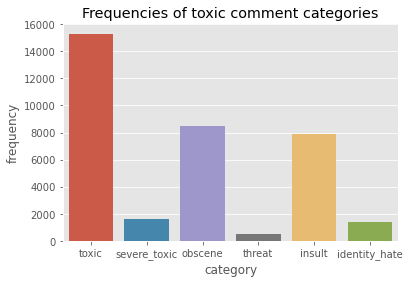

In [16]:
plt.title('Frequencies of toxic comment categories')
sns.barplot(x='category', y='frequency', data=df_category_counts)

Based on the bar chart, we can recognize an imbalanced dataset considering the different classes. However, we keep it simple and don't perform any over- or undersampling techniques as it represents a multi-label classification task and contains multiple labels for each observation. Let's prepare the train and test set by splitting the data into the descriptive features and the target labels.

In [17]:
X_train_untokenized = train['comment_text'].values
y_train = train[labels].values

X_test_untokenized = test['comment_text'].values
y_test = test[labels].values

Depending on the preprocessing flag, we also preprocess the descriptive features (text comments) by removing the stop words and optionally perform stemming. Stemming is basically used for removing the suffix of words to reduce the amount of redundant words within the vocabulary. For example, *plotted* to *plot* or *flying* to *fly*.

Further possible preprocessing steps could be [2]:
* Remove HTML tags
* Remove extra whitespaces
* Convert accented characters to ASCII characters
* Expand contractions
* Remove special characters
* Lowercase all texts
* Convert number words to numeric form
* Remove numbers

**Note:** Some of these steps are automatically performed by the used tokenizers such as the *Tokenizer* class from Keras.

In [18]:
if preprocessing:
    X_train_untokenized = preprocess(X_train_untokenized, stemming=stemming)
    X_test_untokenized = preprocess(X_test_untokenized, stemming=stemming)

Let's visualize a word cloud for a specific type of toxic comment. The index of the labels ranges from 0 to 5 and corresponds to the order of the list `['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']`. In the following, we show the word cloud for all train observations with the label *severe_toxic*. After the generation, we can see the most common words in the text comments which usually results into a severe toxic comment.

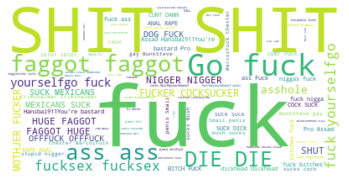

In [19]:
plt.imshow(generate_wordcloud(X_train_untokenized, y_train, 1), interpolation='bilinear')
plt.axis("off")
plt.show()

To enable the documents as input for the machine learning models, we have to tokenize the textual data into tokens whereby each token represents a word of the input sentence. For the Logistic Regression model we use the *TfidfVectorizer* class from sklearn which converts the document to a vector with term frequency–inverse document frequency values. For the deep learning model, we use the *Tokenizer* class of keras which converts the text to a sequence of integers whereby each integer is a index of a token in a dictionary. For limiting the size of the vector, we use a fixed vocabulary size for each tokenizer.

In [20]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word',  
                                   max_features=vocab_size)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_untokenized)
X_test_tfidf =  tfidf_vectorizer.transform(X_test_untokenized)

In [21]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train_untokenized)

X_train_seq = tokenizer.texts_to_sequences(X_train_untokenized)
X_test_seq = tokenizer.texts_to_sequences(X_test_untokenized)

Let's visualize the distribution of the document lengths (sentence lengths) by using the word level. Based on this, we can choose the fixed length for the sequence input of the deep learning model as it expects inputs of the same length.

Text(0, 0.5, 'frequency')

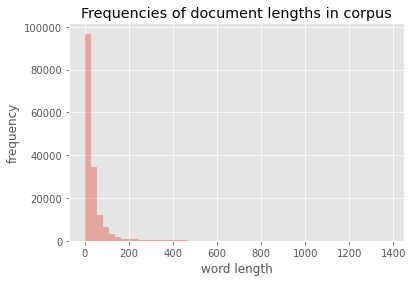

In [22]:
plt.title('Frequencies of document lengths in corpus')
sns.distplot([len(sentence) for sentence in X_train_seq], kde=False)
plt.xlabel('word length')
plt.ylabel('frequency')

## Modeling <a id='modeling'></a>

### Preparation

Regarding the distribution visualization of the document lengths within the train corpus, we choose a fixed sequence length of 150 which covers most of the sentences in the train corpus. Hence, we don't loose too much information by padding or cutting off sentences to a fixed length. The embedding dimension is based on the used weight matrix which is based on the 300-dimensional word2vec embedding. For the deep learning model, we pad the train and test observations to the fixed sequence length of 150.

In [23]:
embedding_dim = 300
sequence_length = 150

In [24]:
X_train_seq = pad_sequences(X_train_seq, maxlen=sequence_length)
X_test_seq = pad_sequences(X_test_seq, maxlen=sequence_length)

### Classical Machine Learning

Classical machine learning models have been used in a wide range of NLP applications. Before we are heading to a more advanced technique with deep learning, a Logistic Regression model is trained based on the tfidf-features which can be used as a simple baseline for later performance comparison. In detail, we wrap the Logistic Regression model into a *MultiOutputClassifier* as our model outcome must predict a label for each of the six types of toxical comments. This classifier simply trains and uses one model for each label. We also search for optimal hyperparameters by applying the grid search technique in 5-fold cross-validation approach.

In [25]:
gs_lr_params = {'estimator__penalty': ['l1', 'l2'],
                'estimator__solver': ['newton-cg', 'lbfgs', 'saga'],
                'estimator__C': [1, 3, 5]}

moc_lr = MultiOutputClassifier(LogisticRegression())

gs_lr = GridSearchCV(moc_lr,
                     param_grid=gs_lr_params,
                     scoring='accuracy',
                     verbose=1,
                     n_jobs=-2)

gs_lr.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-2)]: Done  90 out of  90 | elapsed: 63.3min finished


GridSearchCV(estimator=MultiOutputClassifier(estimator=LogisticRegression()),
             n_jobs=-2,
             param_grid={'estimator__C': [1, 3, 5],
                         'estimator__penalty': ['l1', 'l2'],
                         'estimator__solver': ['newton-cg', 'lbfgs', 'saga']},
             scoring='accuracy', verbose=1)

The best hyperparameters for the multioutput Logistic Regression model are `C=1`, `penalty=l1` and `solver=saga`.

In [26]:
gs_lr.best_params_

{'estimator__C': 1, 'estimator__penalty': 'l1', 'estimator__solver': 'saga'}

In [27]:
print('vaL_acc: %.3f' % gs_lr.best_score_)

vaL_acc: 0.921


### Deep Learning

Deep learning techniques have often outperformed classical machine learning algorithms in NLP tasks. Hence, we want to classify the toxic comments by using a neural network architecture, in particular recurrent and/or convolutional neural networks. It's a difficult task to find the optimal hyperparameters such as the network architecture. For NLP tasks, there exists a bunch of common network types such as the following:

* Gated Recurrent Unit (GRU)
* Long Short-Term Memory (LSTM)
* Bidirectional GRU
* Bidirectional LSTM
* Convolutional GRU
* ...

We are using the simple GRU network as there haven't been shown relevant performance differences among these networks for this text classification task.

In [28]:
X_train_seq, X_valid_seq, y_train, y_valid = train_test_split(X_train_seq, 
                                                              y_train, 
                                                              test_size=0.1, 
                                                              random_state=999)

For contextual word representation, we create an embedding layer which uses the word2vec weight matrix. Let's load the word2vec embedding, create the embedding layer and use it for the GRU network.

In [29]:
embedding_weights = get_embedding_weights(embedding_path, embedding_dim, tokenizer)

In [30]:
embedding_layer = Embedding(vocab_size, 
                            embedding_dim, 
                            weights=[embedding_weights], 
                            trainable=False)

In [31]:
gru = GRU(sequence_length, embedding_layer)

Lastly, we train the neural network with *binary crossentropy* as the loss function, *adam* as the optimizer and *accuracy* as the metric.

In [32]:
batch_size = 64
epochs = 5

In [33]:
earlyStopping = EarlyStopping(monitor='val_acc', patience=2, mode='max')

In [34]:
gru.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
        
gru.fit(X_train_seq, 
        y_train, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(X_valid_seq, y_valid),
        callbacks=[earlyStopping])

Train on 143613 samples, validate on 15958 samples
Epoch 1/5
143613/143613 [==============================] - 575s 4ms/sample - loss: 0.0671 - accuracy: 0.9772 - val_loss: 0.0513 - val_accuracy: 0.9809
Epoch 2/5
143613/143613 [==============================] - 589s 4ms/sample - loss: 0.0512 - accuracy: 0.9813 - val_loss: 0.0483 - val_accuracy: 0.9821
Epoch 3/5
143613/143613 [==============================] - 597s 4ms/sample - loss: 0.0487 - accuracy: 0.9821 - val_loss: 0.0478 - val_accuracy: 0.9814
Epoch 4/5
143613/143613 [==============================] - 620s 4ms/sample - loss: 0.0466 - accuracy: 0.9827 - val_loss: 0.0462 - val_accuracy: 0.9823
Epoch 5/5
143613/143613 [==============================] - 605s 4ms/sample - loss: 0.0453 - accuracy: 0.9831 - val_loss: 0.0494 - val_accuracy: 0.9807


## Evaluation <a id='evaluation'></a>

In this section, we compare the predicted results of both models based on the test set. Therefore, we focus on the classification accuracy and the AUC score. The AUC score is meaningful for the deep learning model as well as the logistic regression classificator which return a probability score for each label. For accuracy, the model default threshold of 0.5 is used.

In [35]:
lr_accuracy = gs_lr.best_estimator_.score(X_test_tfidf, y_test)
lr_y_pred = gs_lr.best_estimator_.predict_proba(X_test_tfidf)
lr_y_pred = np.hstack([np.array(lr_y_pred[i][:, 1])[:, np.newaxis] for i in range(0, len(lr_y_pred))])
lr_auc = roc_auc_score(y_test, lr_y_pred)

In [36]:
_, dl_accuracy = gru.evaluate(X_test_seq, y_test, batch_size=64, verbose=0)
dl_y_pred = gru.predict(X_test_seq)
dl_auc = roc_auc_score(y_test, dl_y_pred)

In [37]:
print('LogisticRegression')
print('Accuracy: %.3f' % (lr_accuracy*100))
print('Auc: %.3f' % (lr_auc*100), '\n')

LogisticRegression
Accuracy: 88.623
Auc: 97.257 



In [38]:
print('Deep Learning-Model')
print('Accuracy: %.3f' % (dl_accuracy*100))
print('Auc: %.3f' % (dl_auc*100), '\n')

Deep Learning-Model
Accuracy: 96.330
Auc: 97.707 



The accuracy-scores show, that the GRU network is outperforming the multioutput logistic regression classificator. In contrast, the AUC-scores are almost similar. Hence, we can conclude that the selection of the threshold based on the application could increase the overall performance of the logistic regression model. Let's have a look at the receiver-operating-characteristic (ROC)-curves for both models.

LogisticRegression


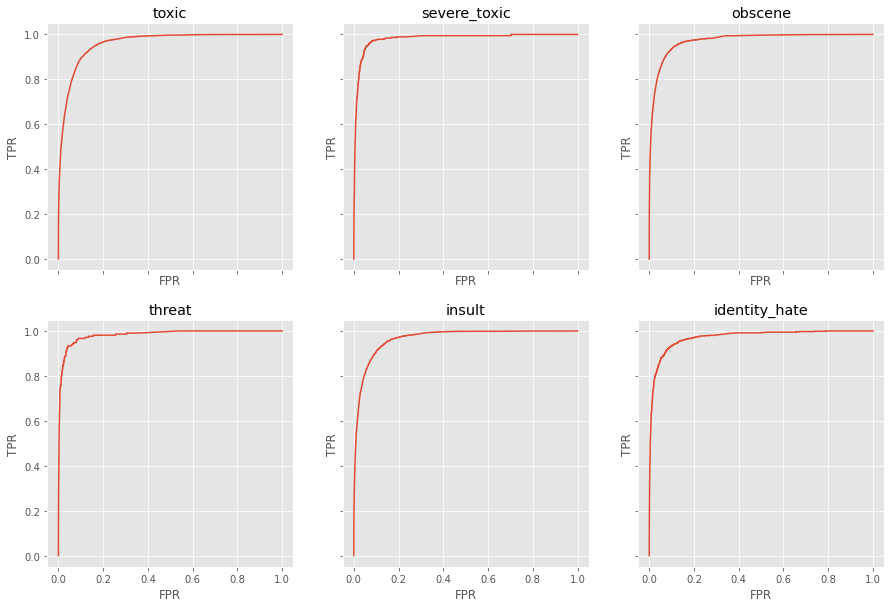

In [39]:
print('LogisticRegression')
plot_roc_curves(y_test, lr_y_pred, labels)

Deep Learning-Model


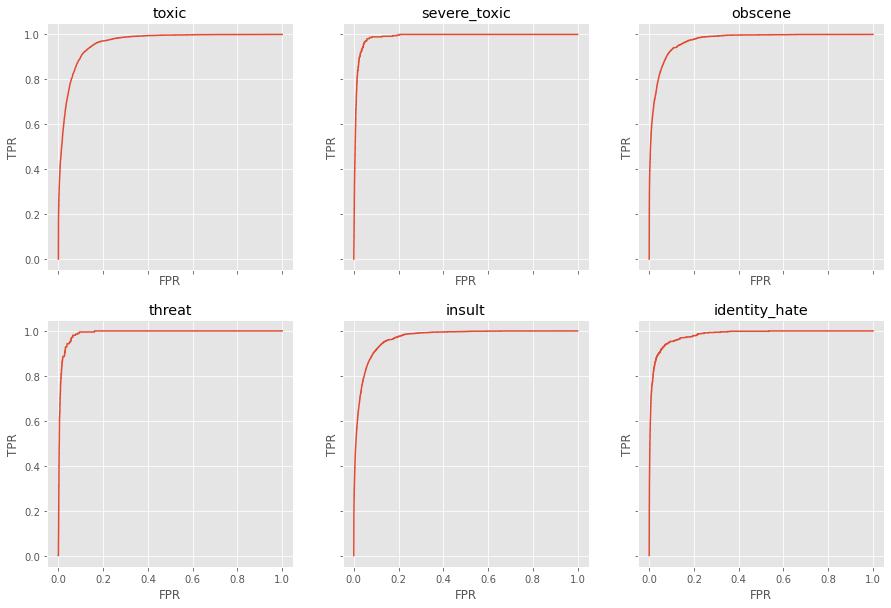

In [40]:
print('Deep Learning-Model')
plot_roc_curves(y_test, dl_y_pred, labels)

Considering all ROC-curves, we can observe that there aren't any significant differences among the various toxic comment labels. Depending on the use-case of such an automatic toxic comment detection, the recall metric and f1-score can represent a more relevant evaluation metric. If we want to detect most of the toxic comments, we can improve the models to increase the recall score. However, only taking the recall into account can lead to a high false-positive rate, which classifies non-toxic comments as toxic comments. Therefore, including a further metric such as the f1-score can deal with this issue by considering the precision-score of the classification models.

## References <a id='references'></a>

[1] Jigsaw/Conversation AI, "Toxic Comment Classification Challenge | Kaggle", Kaggle.com, 2018. [Online]. Available: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge. [Accessed: 10- Sep- 2020].

[2] J. Weng, "NLP Text Preprocessing: A Practical Guide and Template", Medium, 2019. [Online]. Available: https://towardsdatascience.com/nlp-text-preprocessing-a-practical-guide-and-template-d80874676e79. [Accessed: 10- Sep- 2020].

[3] S. Bansal, "A Comprehensive Guide to Understand and Implement Text Classification in Python", Analytics Vidhya, 2018. [Online]. Available: https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/. [Accessed: 10- Sep- 2020].